### Figures for my University of Waterloo colloquium in 2019 Feb.

In [3]:
import os, pdb
import numpy as np
import numpy.ma as ma
import pandas as pd
import fitsio
import warnings
#from scipy.stats import binned_statistic
from matplotlib.ticker import FormatStrFormatter, MultipleLocator, ScalarFormatter
import matplotlib.pyplot as plt

In [4]:
from astropy.io import fits, ascii
from astropy.table import Table, hstack
from astrometry.libkd.spherematch import match_radec

In [5]:
import colossus.halo.mass_so
from colossus.cosmology import cosmology
cosmology.setCosmology('planck18')

In [6]:
import legacyhalos.io
import legacyhalos.misc
from legacyhalos.misc import lambda2mhalo, plot_style
sns, colors = plot_style()

In [7]:
#import seaborn as sns
#sns.set(context='talk', style='ticks', font_scale=1.6)#, palette='deep')
#sns.set_palette('deep', 12)
#colors = sns.color_palette()

In [8]:
%matplotlib inline

In [9]:
datadir = legacyhalos.io.paper2_dir(data=True)
talkdir = os.path.join(legacyhalos.io.legacyhalos_dir(), 'science', 'talks', 'waterloo-2019feb')
print(talkdir)

/Users/ioannis/research/projects/legacyhalos/science/talks/waterloo-2019feb


In [10]:
hdefault = 0.7 # 0.677 # Hubble constant
omega_b = 0.048 # from Knebe+18
omega_m = 0.307 

### Some utility functions.

In [11]:
def mstar_label():
    return r'$\log_{10}\, (\mathcal{M}_{*}\ /\ h^{-2}\, \mathcal{M}_{\odot})$'
def mhalo_label():
    return r'$\log_{10}\, (\mathcal{M}_{\rm halo}\, /\, \mathcal{M}_{\odot})$'
def mstar_label2():
    return r'$\log_{10}\, (\mathcal{M}_{*}\ /\ h^{-1}\, \mathcal{M}_{\odot})$'
def mstar_label3():
    return r'$\log_{10}\, (\mathcal{M}_{*}\, /\, \mathcal{M}_{\odot})$'
def phi_label():
    return r'$\log_{10}\, (\Phi\ /\ h^{3}$ Mpc$^{-3}$ dex$^{-1})$'
def phi_label2():
    return r'$\log_{10}\, (\Phi\ /\ {\rm Mpc}^{-3}\ {\rm dex}^{-1})$'
def mstar_mhalo_label():
    return r'$log_{10}\, (\mathcal{M}_{*}\ /\ \mathcal{M}_{\rm halo})\ /\ (\Omega_b\ /\ \Omega_m)$'

### Compare stellar masses

In [12]:
sample = legacyhalos.io.read_paper2_sample()
lsphot = legacyhalos.io.read_paper2_sample(isedfit_lsphot=True, verbose=True)
sdssphot = legacyhalos.io.read_paper2_sample(isedfit_sdssphot=True, verbose=True)

Read galaxy indices 0 through 1000 (N=1000) from /Users/ioannis/research/projects/legacyhalos/science/paper2/data/paper2-centrals-sfhgrid01-lsphot-dr6-dr7.fits
Read galaxy indices 0 through 1000 (N=1000) from /Users/ioannis/research/projects/legacyhalos/science/paper2/data/paper2-centrals-sfhgrid01-sdssphot-dr14.fits


In [13]:
mhalo = np.log10(lambda2mhalo(sample['LAMBDA_CHISQ'].data, redshift=sample['Z_LAMBDA'].data))

In [14]:
profiles1dmstar = Table.read(os.path.join(datadir, 'paper2-profiles1d-mstar.fits'))
profiles1dmstar.colnames

['MEM_MATCH_ID',
 'RA',
 'DEC',
 'Z',
 'LAMBDA_CHISQ',
 'ID_CENT',
 'RMAX_G',
 'RMAX_R',
 'RMAX_Z',
 'RAD',
 'RAD_AREA',
 'MSTAR10',
 'MSTAR10_ERR',
 'MSTAR30',
 'MSTAR30_ERR',
 'MSTAR100',
 'MSTAR100_ERR',
 'MSTARRMAX',
 'MSTARRMAX_ERR',
 'MSTARRAD',
 'MSTARRAD_ERR',
 'MURAD',
 'MURAD_ERR']

(-0.5, 1)

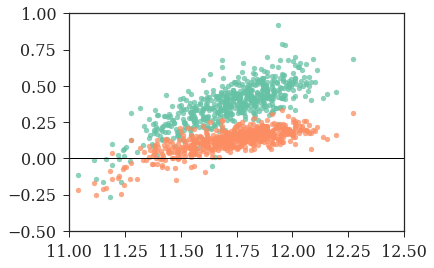

In [15]:
fig, ax = plt.subplots()
ax.scatter(profiles1dmstar['MSTAR100'], profiles1dmstar['MSTAR100']-profiles1dmstar['MSTAR10'], s=25, alpha=0.75)
ax.scatter(profiles1dmstar['MSTAR100'], profiles1dmstar['MSTAR100']-profiles1dmstar['MSTAR30'], s=25, alpha=0.75)
ax.axhline(y=0, color='k', lw=1, ls='-')
ax.set_xlim((11, 12.5))
ax.set_ylim(-0.5, 1)

(-0.5, 1)

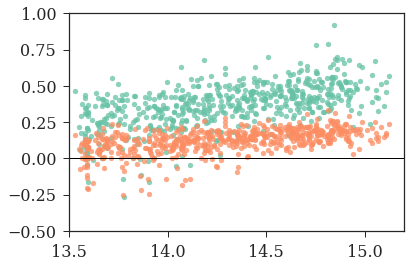

In [16]:
fig, ax = plt.subplots()
ax.scatter(mhalo, profiles1dmstar['MSTAR100']-profiles1dmstar['MSTAR10'], s=25, alpha=0.75)
ax.scatter(mhalo, profiles1dmstar['MSTAR100']-profiles1dmstar['MSTAR30'], s=25, alpha=0.75)
ax.axhline(y=0, color='k', lw=1, ls='-')
ax.set_xlim(13.5, 15.2)
ax.set_ylim(-0.5, 1)

In [17]:
pp = profiles1dmstar[1]
print(pp['MSTARRMAX'])
np.log10(np.cumsum(10**pp['MSTARRAD']))

12.138


array([  9.48366165,   9.96899033,  10.31805611,  10.59861279,
        10.814394  ,  11.00652504,  11.18540478,  11.34167385,
        11.47084522,  11.57597256,  11.66409016,  11.73876095,
        11.80382347,  11.86020088,  11.90914249,  11.95125294,
        11.98646927,  12.01755142,  12.04685879,  12.07443714,
        12.09797859,  12.1207695 ,  12.14068794,  12.15679836,
        12.1698904 ,  12.18043995,  12.189744  ,  12.19788074,
        12.20529842,  12.21057034], dtype=float32)

In [62]:
def mean_profile(mhalomin=14, mhalomax=14.5, R200norm=True):
    ww = np.where((mhalo > mhalomin) * (mhalo < mhalomax))[0]
    
    if R200norm:
        medmhalo, medz = np.median(mhalo[ww]), 0.3 # np.median(profiles1dmstar['Z'][ww])
        rnorm = colossus.halo.mass_so.M_to_R(10**medmhalo, medz, '200c') # use Z_LAMBDA here!
    else:
        rnorm = 1.0

    radfrac, mstarfrac = [], []
    for pp in profiles1dmstar[ww]:
        if pp['MSTAR100'] > 0:
            good = pp['MSTARRAD'] > 0
            mstarsum = np.log10(np.cumsum(10**pp['MSTARRAD'][good]))
            #if R200norm:
            #    rnorm = colossus.halo.mass_so.M_to_R(10**mhalo[ww[ii]], pp['Z'], '200c') # use Z_LAMBDA here!
            #else:
            #    rnorm = 1.0
            radfrac.append(np.log10(pp['RAD'][good] / rnorm)) # normalize by R200!
            mstarfrac.append(mstarsum)
            #mstarfrac.append(10**(mstarsum-mstarsum[-1]))

    stats = legacyhalos.misc.statsinbins(np.hstack(radfrac), np.hstack(mstarfrac), binsize=0.1)
    return stats, radfrac, mstarfrac

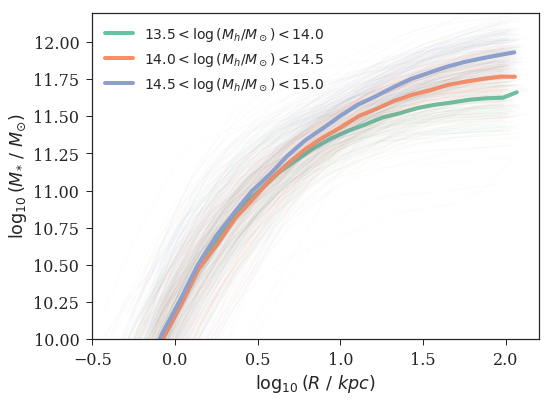

In [67]:
R200norm = False
dmhalo = 0.5
mhalomin = np.arange(13.5, 15, dmhalo)
mhalomax = mhalomin + dmhalo

fig, ax = plt.subplots(figsize=(8, 6))
for ii, (hmin, hmax) in enumerate(zip(mhalomin, mhalomax)):
    stats, radfrac, mstarfrac = mean_profile(hmin, hmax, R200norm=R200norm)
    ax.plot(stats['xmean'], stats['ymean'], lw=4, color=colors[ii], 
            label=r'${:.1f}<\log\,(M_h/M_\odot)<{:.1f}$'.format(hmin, hmax))
    for rr, mm in zip(radfrac, mstarfrac):
        ax.plot(rr, mm, lw=1, alpha=0.03, color=colors[ii])
        
#ax.axhline(y=0.5, ls='--')
#ax.axvline(x=-1, ls='--')

ax.legend(loc='upper left', fontsize=14)
ax.set_ylabel(r'$\log_{10}\,(M_{*}\ /\ M_{\odot})$')
#ax.set_ylim(0, 1.02)
ax.set_ylim(10, 12.2)

if R200norm:
    ax.set_xlim(-3.5, -0.05)
    ax.set_xlabel(r'$\log_{10}\,(R\ /\ R_{200c})$')
else:
    ax.set_xlim(-0.5, 2.2)
    ax.set_xlabel(r'$\log_{10}\,(R\ /\ kpc)$')   

(6, 10.5)

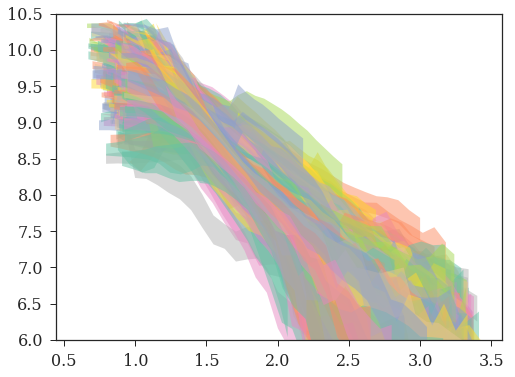

In [48]:
fig, ax = plt.subplots(figsize=(8, 6))
for pp in profiles1dmstar:
    good = pp['MURAD'] > 0
    if np.sum(good) > 0:
        #ax.plot(pp['RAD'][good], pp['MURAD'][good], lw=1)
        ax.fill_between(pp['RAD'][good]**0.25, 
                        pp['MURAD'][good]-pp['MURAD_ERR'][good], 
                        pp['MURAD'][good]+pp['MURAD_ERR'][good],
                        lw=1, alpha=0.5)        
#ax.axhline(y=0, color='k', lw=1, ls='-')
#ax.set_xlim(0, 130)
ax.set_ylim(6, 10.5)

In [78]:
def qa_smhm_obs(aperture='10kpc', png=None):
    
    lambda_chisq, z = sample['LAMBDA_CHISQ'], sample['Z_LAMBDA']
    mstar, mstarerr = profiles1dmstar['MSTARRMAX'], profiles1dmstar['MSTAR100_ERR']
    #print(mstar, mstarerr)
    #mstar, mstarerr = profiles1dmstar['MSTARRMAX'], profiles1dmstar['MSTARRMAX_ERR']
    rich = lambda_chisq > 100
    
    mhalo = np.log10(lambda2mhalo(lambda_chisq, redshift=z))
    #stats = statsinbins(mhalo, mstar)    
    
    col = iter(colors)
    fig, ax = plt.subplots(figsize=(10, 7))
    
    #ax.plot(stats['xmedian'], stats['ymedian'], color='k', ls='-', lw=3, alpha=0.5)
    #ax.plot(stats['xmedian'], stats['y75'], color='k', ls='--', lw=3, alpha=0.5)
    #ax.plot(stats['xmedian'], stats['y25'], color='k', ls='--', lw=3, alpha=0.5)

    gonz = legacyhalos.io.literature(gonzalez=True, kravtsov=False)
    krav = legacyhalos.io.literature(kravtsov=True, gonzalez=False)
    
    g = ax.errorbar(gonz['m500'], gonz['mbcg'], yerr=gonz['mbcg_err'], color=next(col),
                    fmt='o', label='Gonzalez+13', markersize=10)
    k = ax.errorbar(krav['m500'], krav['mbcg'], yerr=krav['mbcg_err'], color=next(col),
                    fmt='s', label='Kravtsov+18', markersize=10)
    #r = ax.scatter(mhalo[rich], mstar[rich], alpha=0.9, color=next(col),
    #               edgecolor='k', marker='D', s=50, label='\emph{legacyhalos} ($\lambda>100$)')
    r = ax.scatter(mhalo, mstar, alpha=0.9, color=next(col),
                   edgecolor='k', marker='D', s=50, label='\emph{legacyhalos} ($\lambda>100$)')
    #r = ax.errorbar(mhalo, mstar, yerr=mstarerr, alpha=0.9, color=next(col),
    #                marker='D', label='\emph{legacyhalos} ($\lambda>100$)')

    ax.text(0.12, 0.16, '\emph{legacyhalos}\n$z\sim0.2$', multialignment='center',
            transform=ax.transAxes, fontsize=18)
    #ax.text(0.12, 0.16, 'redMaPPer\n$0.1<z<0.3$', multialignment='center',
    #        transform=ax.transAxes, fontsize=14)
    
    m500 = np.linspace(13.55, 15.25, 50)
    ff = ax.plot(m500, np.polyval([0.33, 12.24], m500-14.5)+2*np.log10(0.7), ls='-', 
                color='k', label=r'$\mathcal{M}_{*}\propto \mathcal{M}_{halo}^{0.33}$')
    ax.text(0.12, 0.9, r'$\mathcal{M}_{*}\propto \mathcal{M}_{halo}^{0.33}$', multialignment='center',
            transform=ax.transAxes, fontsize=18)
    #ax.plot([13.55, 13.68], [12.8, 12.8]+2*np.log10(0.7), ls='-', color='k') # hack!!!
    ax.plot([13.55, 13.68], [12.65, 12.65], ls='-', color='k') # hack!!!
    
    #mh = np.log10(lambda2mhalo(cat2['lambda_chisq'], redshift=cat2['z_1']))
    #ms = cat2['mstar_avg']
    #ax.scatter(mh, ms, s=10, color='orange', alpha=0.2)

    #ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.xaxis.set_major_locator(MultipleLocator(0.5))
    ax.yaxis.set_major_locator(MultipleLocator(0.5))

    hh = [g, k, r]
    ax.legend(hh, [H.get_label() for H in hh], loc='lower right',
              frameon=True, fontsize=16)
    #ax.legend(ff, ff.get_label(), loc='upper left',
    #          frameon=True, fontsize=16)
    #ax.legend(loc='upper left', frameon=True, fontsize=16)

    ax.set_ylim(10.5, 12.8)
    #ax.set_ylim(10.5, 13)
    ax.set_xlim(13.5, 15.3)

    ax.set_xlabel(r'$\log_{10}\, (\mathcal{M}_{halo}\ /\ \mathcal{M}_{\odot})$')
    ax.set_ylabel(r'$\log_{10}\, (\mathcal{M}_{*}\ /\ \mathcal{M}_{\odot})$')
    
    plt.subplots_adjust(left=0.18)
    
    if png:
        plt.savefig(os.path.join(talkdir, png))    

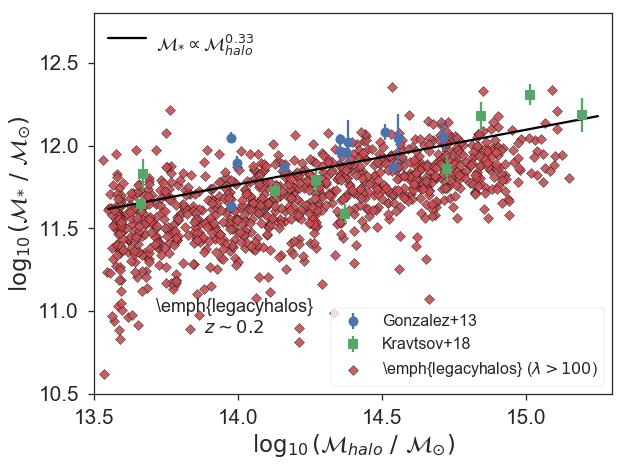

In [79]:
qa_smhm_obs()

In [ ]:
stop

In [9]:
lhphot2 = Table(fitsio.read(os.path.join(legacyhalos_dir, 'redmapper-upenn.fits'), 
                           ext='REDMAPPER', lower=True))
m1, m2, d12 = match_radec(lhphot['ra'], lhphot['dec'], lhphot2['ra'], lhphot2['dec'],
                          1/3600.0, nearest=True)
lhphot2 = lhphot2[m2]

In [10]:
lsisedfit = legacyhalos.io.read_parent(extname='LSPHOT-ISEDFIT', upenn=True, isedfit=True, verbose=True)
sdssisedfit = legacyhalos.io.read_parent(extname='SDSSPHOT-ISEDFIT', upenn=True, isedfit=True, verbose=True)

Read 53441 objects from /Users/ioannis/research/projects/legacyhalos/legacyhalos-parent-isedfit.fits [LSPHOT-ISEDFIT]
Read 53441 objects from /Users/ioannis/research/projects/legacyhalos/legacyhalos-parent-isedfit.fits [SDSSPHOT-ISEDFIT]


### Stellar mass - halo mass relation

In [11]:
cat = legacyhalos.io.read_parent(extname='LSPHOT-ISEDFIT', upenn=False, 
                                   isedfit=True, columns=('mstar_avg', 'sfr100_avg'))
cat1 = legacyhalos.io.read_parent(extname='REDMAPPER', upenn=False, 
                                   isedfit=False, columns=('Z', 'LAMBDA_CHISQ'))
cat = hstack( (cat, cat1) )

cat2 = hstack( (lhphot, lhphot2) )
print(len(cat))

53441


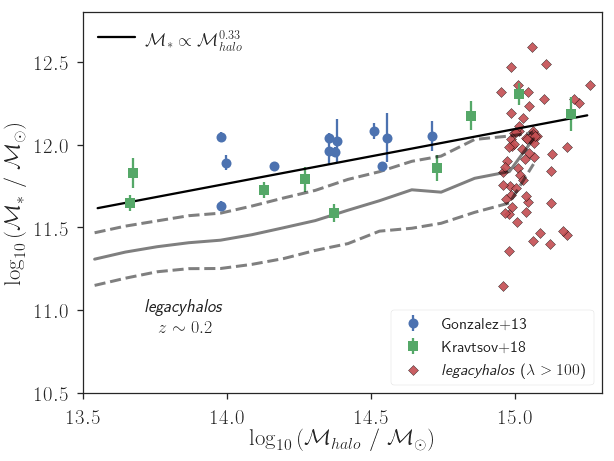

In [73]:
qa_smhm_obs(cat, cat2, png='mstar-mhalo.png')

#### From Mendel+14, Table 3 is "dust" (lower masses) and Table 5 is "no dust" (higher masses).

In [14]:
def qa_deltamass(xmass, ymass, xlabel=None, ylabel=None, xlim=None, 
                 hexbin=False, png=None, huang=False):
    
    deltamass = xmass - ymass
    stats = statsinbins(xmass, deltamass, binsize=0.1, minpts=20, xmin=11, xmax=12)
    print(stats['ymedian'])

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.axhline(y=0, ls='--', color='gray')
    if hexbin:
        ax.hexbin(xmass, deltamass, gridsize=200, mincnt=2, bins='log', 
          cmap='viridis', extent=(10, 12.5, -0.5, 0.5), alpha=0.75)
    else:
        ax.scatter(xmass, deltamass, marker='s', edgecolor='k', alpha=0.5, s=10)
    ax.plot(stats['xbin'], stats['ymedian'], lw=2, ls='-', color='k')
    ax.plot(stats['xbin'], stats['y75'], lw=2, ls='--', color='k')
    ax.plot(stats['xbin'], stats['y25'], lw=2, ls='--', color='k')
    if xlim is None:
        ax.set_xlim(10.5, 12.3)
    ax.set_ylim(-0.5, 0.5)
    if xlabel:
        ax.set_xlabel(r'$\log_{10}\, (\mathcal{M}_{*}\, /\, \mathcal{M}_{\odot})$')
        #ax.set_xlabel(r'$log_{{10}}\, (\mathcal{{M}}_{{*}}\, /\, \mathcal{{M}}_{{\odot}})\ ({{\rm {} }})$'.format(xlabel))
    if ylabel:
        #ax.set_ylabel(r'$\Delta\,\log_{{10}}(\mathcal{{M}}\,/\,M_{{\odot}})\ \n({{\rm {} }})$'.format(ylabel))
        #ax.set_ylabel(r'$\Delta\,\log_{10}(\mathcal{M}\,/\,M_{\odot})$\\'+'({})'.format(ylabel))
        ax.set_ylabel(r'$\Delta\,\log_{10}(\mathcal{M}\,/\,\mathcal{M}_{\odot})$')
    ax.xaxis.set_major_locator(MultipleLocator(0.5))
    ax.grid()    
    
    if huang:
        xh = np.array([11.129281767955801,11.318232044198895,11.49060773480663,
              11.662983425414364,11.865193370165745])
        yh = np.array([0.0423728813559322,0.05254237288135588,0.06779661016949157,
              0.09322033898305082,0.14067796610169492])
        yerr = np.array([0.08, 0.08, 0.12, 0.14, 0.15])
        ax.errorbar(xh, yh, yerr=yerr, fmt='s', color='red',
                   capthick=2, alpha=0.6, ecolor='red', capsize=10,
                   label=r'Huang+18')
        handles, labels = ax.get_legend_handles_labels()
        #pdb.set_trace()
        print(len(labels))
        ax.legend(handles[::-1][0:1], labels[::-1][0:1], loc='upper left',
                 fontsize=18)
    
    plt.subplots_adjust(left=0.18, right=0.95, bottom=0.18, top=0.95)
    
    if png:
        plt.savefig(os.path.join(talkdir, png))

In [15]:
lhphot_mstar = lhphot['mstar_avg']
lsphot_mstar = lsphot['mstar_avg']
mendel_tab5_mstar = upenn['mstar_tab5_mendel']
mendel_tab3_mstar = upenn['mstar_tab3_mendel']
sdssphot_mstar = sdssphot['mstar_avg']

good = ( (lhphot_mstar > 0) * (mendel_tab3_mstar > 0) * (mendel_tab5_mstar > 0) * 
        (sdssphot_mstar > 0) * (lsphot_mstar > 0) )

lhphot_mstar = lhphot_mstar[good]
mendel_tab3_mstar = mendel_tab3_mstar[good]
mendel_tab5_mstar = mendel_tab5_mstar[good]
lsphot_mstar = lsphot_mstar[good]
sdssphot_mstar = sdssphot_mstar[good]

[-0.02545166 -0.02133942 -0.02553034 -0.02002048 -0.01121569 -0.01544666
 -0.01468611 -0.00900364 -0.00895786 -0.00320435 -0.00034285  0.0078969
  0.0104723   0.01846027  0.011724    0.04391479  0.03032398  0.05489159
  0.04955053]
2


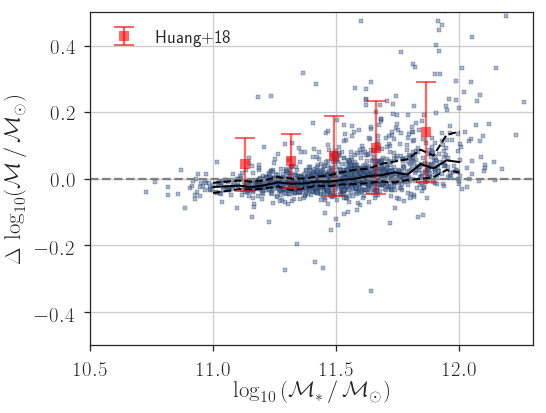

In [16]:
qa_deltamass(lsphot_mstar, sdssphot_mstar, ylabel='legacyhalos-SDSS', 
             xlabel='legacyhalos', png='mstar-legacyhalos-sdss.png',
             huang=True)

In [17]:
lsmass = lsisedfit['mstar_avg'].data
sdssmass = sdssisedfit['mstar_avg'].data

[-0.11453187 -0.08286154 -0.07415444 -0.04678961 -0.11147185 -0.06378045
 -0.05199507 -0.07495751 -0.07707422 -0.05572732 -0.07180296 -0.06002824
 -0.06348474 -0.06358679 -0.0735216  -0.06557631 -0.07660833 -0.05178808
 -0.07072263 -0.02970985 -0.05316842 -0.02477418]


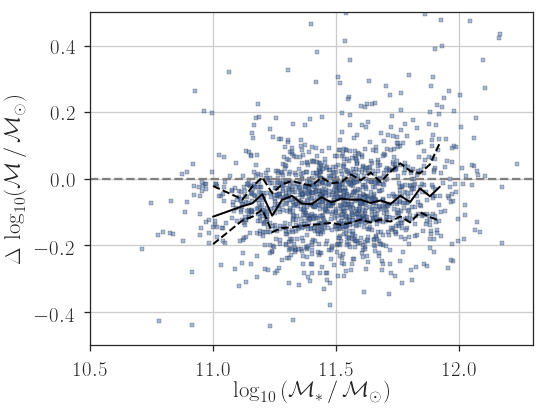

In [18]:
qa_deltamass(lhphot_mstar, mendel_tab5_mstar, ylabel='legacyhalos minus Bernardi17', 
             xlabel='legacyhalos', png='mstar-legacyhalos-bernardi.png')

[-0.04843483 -0.03306826 -0.00804556 -0.00090638  0.00969584  0.00248224
  0.00847619  0.03781072  0.05013622  0.04712607  0.05817761  0.09593251
  0.09336715  0.10169238  0.10491645  0.1154663 ]


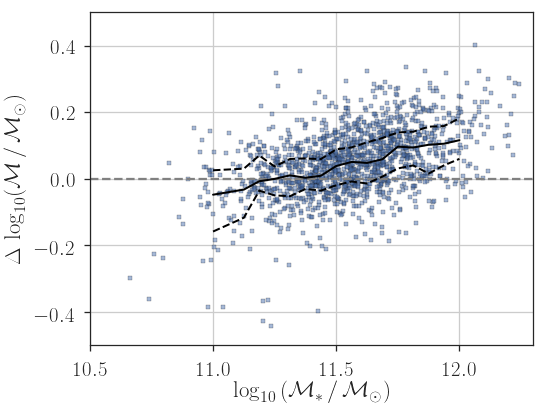

In [19]:
qa_deltamass(mendel_tab5_mstar, sdssphot_mstar, ylabel='Bernardi17-SDSS', xlabel='Bernardi17')

[-0.02724504 -0.02992535 -0.0278883  -0.02323914 -0.03428936 -0.02971554
 -0.03031158 -0.0342679  -0.03164864 -0.02534294 -0.0253973  -0.02865219
 -0.02299118 -0.02746868 -0.02412796 -0.02336502 -0.02912855 -0.02477074
 -0.02740097 -0.03441429 -0.03156662 -0.0355854 ]


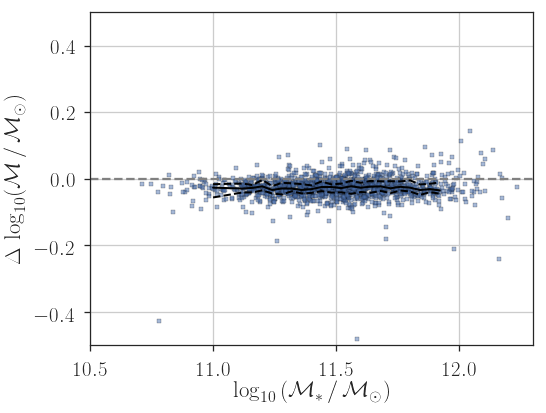

In [20]:
qa_deltamass(lhphot_mstar, lsphot_mstar, ylabel='legacyhalos-LegacySurvey', xlabel='legacyhalos')

[ 0.02336311  0.03395176  0.03332949  0.03086567  0.03182602  0.03713083
  0.03560877  0.03684807  0.03548527  0.0357933   0.03472805  0.0367384
  0.04105377  0.04049683  0.0375886   0.04081297  0.04279232  0.0406847
  0.03997231  0.04189825  0.04328823  0.04025078  0.04131317  0.04402542
  0.04307175  0.04056787  0.03966284  0.04286289  0.0432682   0.03996897
  0.04370785  0.04526806  0.04516315  0.04875755  0.05001259  0.05207348
  0.05897331  0.06266308  0.07457209  0.06412506  0.07848406  0.11704445
  0.09697914  0.17155075  0.14258575]


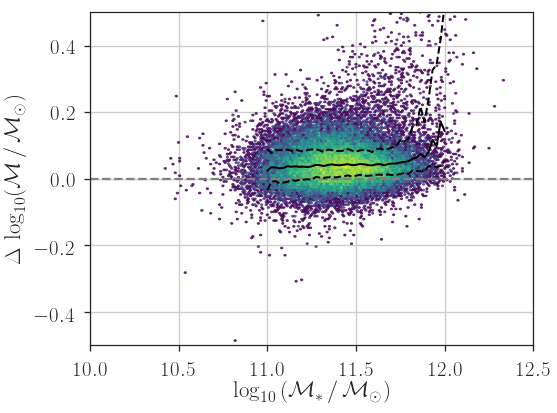

In [21]:
qa_deltamass(lsmass, sdssmass, ylabel='legacyhalos-SDSS', xlabel='legacyhalos', 
             hexbin=True, xlim=(10, 12.5))

### Ellipse-fitting results

In [22]:
from legacyhalos.io import analysis_dir, read_ellipsefit, read_multiband, read_sky_ellipsefit
from legacyhalos.qa import display_multiband, display_ellipsefit, _display_ellipse_sbprofile

In [23]:
objid, objdir = '0003497', os.path.join(analysis_dir(), '0003497')
ellipsefit = read_ellipsefit(objid, objdir)
skyellipsefit = read_sky_ellipsefit(objid, objdir)
data = read_multiband(objid, objdir)

In [24]:
sbprofilefile = os.path.join(talkdir, '{}-ellipse-sbprofile.png'.format(objid))
_display_ellipse_sbprofile(ellipsefit, skyellipsefit=skyellipsefit, minerr=0.0,
                           png=sbprofilefile, verbose=True, use_ylim=(18, 33))

Writing /Users/ioannis/research/talks/legacyhalos/scaling-relations-2018jul/0003497-ellipse-sbprofile.png


In [25]:
multibandfile = os.path.join(talkdir, '{}-ellipse-multiband.png'.format(objid))
display_multiband(data, ellipsefit=ellipsefit, png=multibandfile, verbose=True, vertical=True)

Writing /Users/ioannis/research/talks/legacyhalos/scaling-relations-2018jul/0003497-ellipse-multiband.png


### Toy stellar mass function and SMHM relation

In [26]:
def qa_smf(png=None):
    """A toy SMF."""
    
    # Halo mass function from Tinker's code 
    #   http://cosmo.nyu.edu/~tinker/massfunction/mf.html
    # with ./massfunction.x mf-toy.bat
    
    mh, dndm = np.loadtxt(os.path.join(talkdir, 'toy.dndM'), unpack=True)
    mh, dndm = np.log10(mh), np.log10(dndm)
    
    # SMF
    mstarlim = (9, 12)
    mstar = np.linspace(8, 12, 50)
    alpha = -1.2
    mstar0 = 10.7
    
    phi = np.zeros_like(mstar)
    phi += (alpha + 1) * (mstar - mstar0) * np.log(10)
    phi -= pow(10, mstar - mstar0)
    #phierr = np.polyval([0.05, 0.25], mstar-mstar0)
    #phierr[phierr < 0.1] = 0.1
    phierr = 0.12*np.abs(phi)
    phierr[phierr < 0.05] = 0.05
    
    fig, ax = plt.subplots(figsize=(10, 7))
    #keep = (mstar > 9.1) * (phi > -4.95)
    #ax.fill_between(mstar[keep], phi[keep]-0.2, phi[keep]+0.2, alpha=0.7)
    ax.fill_between(mstar, phi+phierr, phi-phierr, alpha=0.7,
                    label='Stellar Mass Function')
    
    ax.plot(mh-4, dndm+19.3, color=colors[1], lw=4, ls='--',
            label='Halo Mass Function')
    
    #ax.plot(mstar, phi)
    ax.grid()
    #ax.set_xlim(mstarlim)
    #ax.set_ylim(-5, 1.5)
    ax.set_xlim(9, 12)
    ax.set_ylim(-7, 3)
    
    #ax.set_yscale('log')
    
    #ax.set_yticks([0.004, 0.01, 0.03, 0.1, 0.3])
    #ax.get_yaxis().set_major_formatter(ScalarFormatter())

    ax.set_xlabel(mstar_label3())
    ax.set_ylabel(r'$\log_{10}\ {\rm (Number\ Density)}$')
    
    ax.legend(loc='upper right')
    
    if png:
        plt.savefig(os.path.join(talkdir, png))

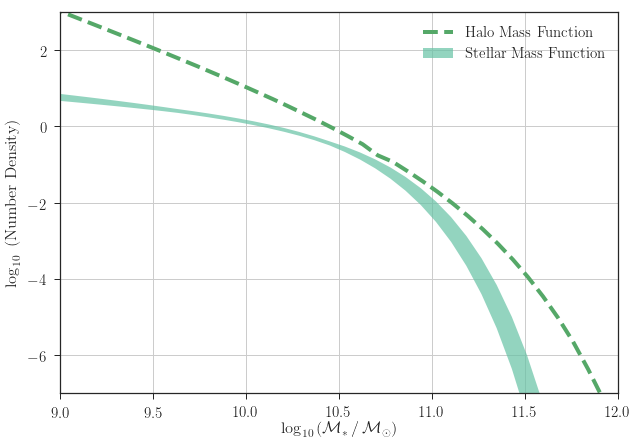

In [27]:
qa_smf(png='toy-smf.png')

In [28]:
def qa_smhm_relation(png=None):
    """Data taken from Behroozi+13."""
    mhalo, mstar_mhalo, errlo, errup = np.loadtxt(os.path.join(
        os.getenv('CATALOGS_DIR'), '13behroozi',  'smmr', 
        'c_smmr_z0.10_red_all_smf_m1p1s1_bolshoi_fullcosmos_ms.dat'),
                                              unpack=True)
    keep = mhalo > 11.2
    mstar_mhalo = mstar_mhalo[keep]
    mhalo = mhalo[keep]
    errlo = errlo[keep]
    errup = errup[keep]
    
    sfe = 10**(mstar_mhalo + np.log10(omega_m / omega_b))
    sfe_up = 10**(mstar_mhalo + errup + np.log10(omega_m / omega_b))
    sfe_lo = 10**(mstar_mhalo - errlo + np.log10(omega_m / omega_b))
    keep = sfe > 0.004

    fig, ax = plt.subplots(figsize=(10, 7))
    ax.fill_between(mhalo[keep], sfe_lo[keep], sfe_up[keep], alpha=0.7)
    #ax.plot(mhalo, sfe)
    ax.grid()
    ax.set_xlim(11, 15)
    ax.set_ylim(0.003, 0.4)
    ax.set_yscale('log')
    
    ax.set_yticks([0.004, 0.01, 0.03, 0.1, 0.3])
    ax.get_yaxis().set_major_formatter(ScalarFormatter())

    ax.set_xlabel(mhalo_label())
    ax.set_ylabel(mstar_mhalo_label())
    
    #ax.text(11.2, 0.006, 'Central Galaxies', va='center', 
    #        ha='left', fontsize=20, style='italic')
    
    if png:
        plt.savefig(os.path.join(talkdir, png))    

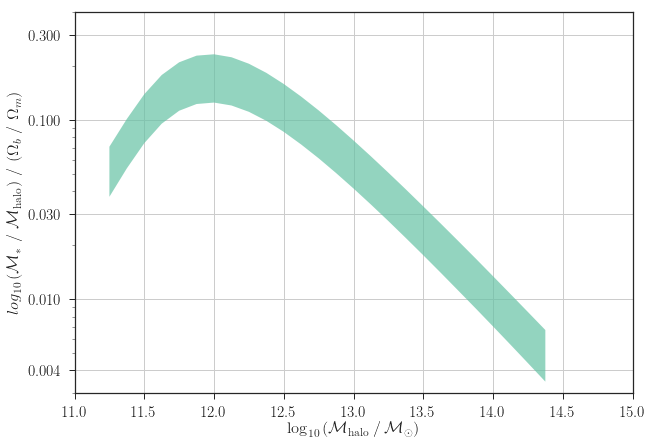

In [29]:
qa_smhm_relation(png='toy-smhm.png')

### Model stellar mass-halo mass relation

Data taken from Knebe+18.

In [50]:
sns.set_palette('deep', 12)

In [51]:
def read_carnage_smhm(fullrange=False, seed=None, h=hdefault):
    """Data taken from Knebe+18."""
    
    carnagedir = os.path.join(os.getenv('CATALOGS_DIR'), 'carnage')
    
    labels = ('DLB07', 'GalICS2.0', 'LGALAXIES', 'SAG', 'MICE', 
              'SAGE', 'Galform-GP14', 'MORGANA', 'ySAM')    
    data = []
    for model in ('DLB07-c01.txt', 'GalICS2.0-c01.txt', 'LGALAXIES-c01.txt',
                  'SAG-c01.txt', 'MICE-c01.txt', 'SAGE-c01.txt', 
                  'Galform-GP14-c01.txt', 'MORGANA-c01.txt', 'ySAM-c01.txt'):
        dd = ascii.read(os.path.join(carnagedir, 'Fig.11a', model), 
                        format='basic', names=('mhalo', 'mstar_mhalo', 'junk1', 
                                               'junk2', 'junk3', 'junk4'),
                        exclude_names=('junk1', 'junk2', 'junk3', 'junk4'))
        #good = np.where( np.isfinite(dd['phi']) * (dd['mstar'] > 0) )[0]
        #dd = dd[good]
        
        dd['mhalo'] = np.log10(dd['mhalo'] / h)
        dd['mstar_mhalo'] = dd['mstar_mhalo'] * omega_m / omega_b
        #dd['mstar_mhalo'] = np.log10(dd['mstar_mhalo'])
        data.append(dd)
        
    if fullrange:
        rand = np.random.RandomState(seed)
        
        mhalo, mstar_mhalo = [], []
        for dd in data:
            #good = np.where( np.isfinite(dd['phi']) * (dd['mstar'] > 0) )[0]
            mhalo.append(dd['mhalo'] + rand.normal(loc=0, scale=0.2))
            mstar_mhalo.append(dd['mstar_mhalo'])
        mhalo = np.hstack(mhalo)
        mstar_mhalo = np.hstack(mstar_mhalo)
        #print(mstar_mhalo)
        
        width = 0.5
        mhalorange = (10, 15.5)
        nbins = np.int(np.ptp(mhalorange) / width)
        
        mstar_mhalomin, mhalo_edges, _ = binned_statistic(mhalo, mstar_mhalo, statistic='min', 
                                                          bins=nbins, range=mhalorange)
        mstar_mhalomax, _, _ = binned_statistic(mhalo, mstar_mhalo, statistic='max', 
                                                bins=nbins, range=mhalorange)
        mhalo = mhalo_edges[1:] - width / 2
        
        good = np.isfinite(mhalo) * np.isfinite(mstar_mhalomin) * np.isfinite(mstar_mhalomax)
        return mhalo[good], mstar_mhalomin[good], mstar_mhalomax[good]
    
    else:
        return data, labels

In [52]:
def qa_carnage_smhm(individual=True, fullrange=False, png=None, ylim=None):
    
    fig, ax = plt.subplots(figsize=(10, 7))
    if individual:
        data, labels = read_carnage_smhm()
        ls = ('-', '--', '-.', ':')
        for dd, ll in zip(data, labels):
            ax.plot(dd['mhalo'], dd['mstar_mhalo'], label=ll, lw=4,
                    ls=ls[0], alpha=0.8)
            ls = np.roll(ls, 1)

    if fullrange:
        mhalo, mstar_mhalomin, mstar_mhalomax = read_carnage_smhm(fullrange=True, seed=1)
        #print(mhalo, mstar_mhalomin, mstar_mhalomax)
        ax.fill_between(mhalo, mstar_mhalomin, mstar_mhalomax, alpha=0.2, color='gray',
                       label='All CARNage Models')

    ax.grid()
    ax.set_xlim(11, 15)
    ax.set_ylim(0.003, 0.4)
    ax.set_yscale('log')
    
    ax.set_yticks([0.004, 0.01, 0.03, 0.1, 0.3])
    ax.get_yaxis().set_major_formatter(ScalarFormatter())

    ax.set_xlabel(mhalo_label())
    ax.set_ylabel(mstar_mhalo_label())
    ax.legend(loc='lower left', ncol=2, fontsize=16)
    
    plt.subplots_adjust(left=0.15, right=0.97, bottom=0.16, top=0.95)
    
    if png:
        plt.savefig(os.path.join(talkdir, png))

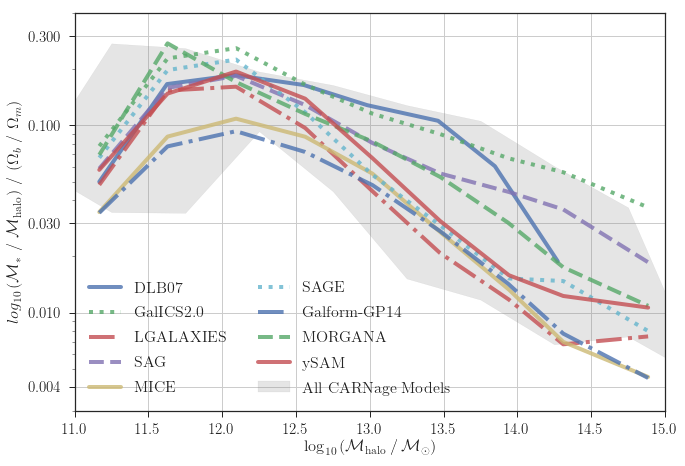

In [53]:
qa_carnage_smhm(fullrange=True, png='smhm-carnage-fullrange.png')

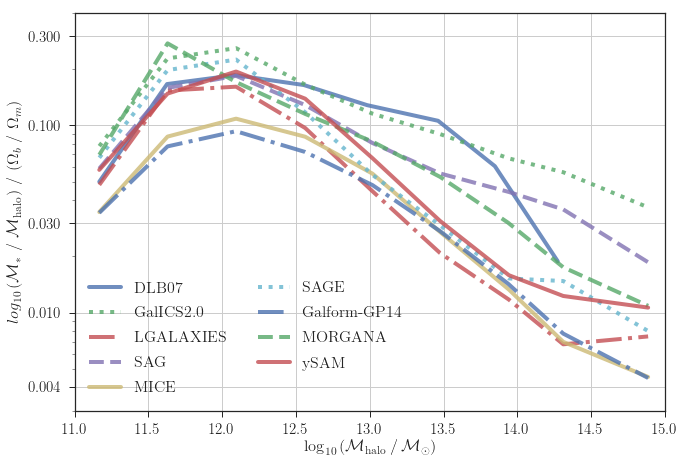

In [54]:
qa_carnage_smhm(png='smhm-carnage.png')

### Model stellar mass functions

Data taken from Knebe+18.

In [55]:
def read_carnage_smf(fullrange=False, seed=None, h=hdefault):
    """Data taken from Knebe+18."""
    
    carnagedir = os.path.join(os.getenv('CATALOGS_DIR'), 'carnage')
    
    labels = ('DLB07', 'GalICS2.0', 'LGALAXIES', 'SAG', 'MICE', 
              'SAGE', 'Galform-GP14', 'MORGANA', 'ySAM')    
    data = []
    for model in ('DLB07-c01.txt', 'GalICS2.0-c01.txt', 'LGALAXIES-c01.txt',
                  'SAG-c01.txt', 'MICE-c01.txt', 'SAGE-c01.txt', 
                  'Galform-GP14-c01.txt', 'MORGANA-c01.txt', 'ySAM-c01.txt'):
        dd = ascii.read(os.path.join(carnagedir, 'Fig.1', model), 
                        format='basic', names=('mstar', 'phi', 'junk1', 'junk2', 'junk3'),
                        exclude_names=('junk1', 'junk2', 'junk3'))
        good = np.where( np.isfinite(dd['phi']) * (dd['mstar'] > 0) )[0]
        dd = dd[good]
        
        dd['mstar'] = np.log10(dd['mstar'] / h)
        dd['phi'] = np.log10(dd['phi'] * h**3)
        data.append(dd)
        
    if fullrange:
        rand = np.random.RandomState(seed)
        
        mstar, phi = [], []
        for dd in data:
            #good = np.where( np.isfinite(dd['phi']) * (dd['mstar'] > 0) )[0]
            mstar.append(dd['mstar']+ rand.normal(loc=0, scale=0.05))
            phi.append(dd['phi'])
        mstar = np.hstack(mstar)
        phi = np.hstack(phi)
        
        width = 0.2
        mstarrange = (9.1, 12.5)
        nbins = np.int(np.ptp(mstarrange) / width)
        
        phimin, mstar_edges, _ = binned_statistic(mstar, phi, statistic='min', bins=nbins, 
                                                  range=mstarrange)
        phimax, _, _ = binned_statistic(mstar, phi, statistic='max', bins=nbins,
                                                  range=mstarrange)
        mstar = mstar_edges[1:] - width / 2
        
        return mstar, phimin, phimax
    else:
        return data, labels

In [56]:
def qa_carnage_smf(individual=True, fullrange=False, png=None, ylim=None):
    fig, ax = plt.subplots(figsize=(10, 7))
    if individual:
        data, labels = read_carnage_smf()
        ls = ('-', '--', '-.', ':')
        for dd, ll in zip(data, labels):
            ax.plot(dd['mstar'], dd['phi'], label=ll, lw=4,
                    ls=ls[0], alpha=0.8)
            ls = np.roll(ls, 1)

    if fullrange:
        mstar, phimin, phimax = read_carnage_smf(fullrange=True, seed=1)
        ax.fill_between(mstar, phimin, phimax, alpha=0.2, color='gray',
                       label='All CARNage Models')

    ax.grid()
    ax.set_xlim(9, 12.5)
    if ylim:
        ax.set_ylim(ylim)

    ax.set_xlabel(mstar_label2())
    ax.set_ylabel(phi_label())
    ax.legend(loc='lower left', ncol=2, fontsize=16)
    
    if png:
        plt.savefig(os.path.join(talkdir, png))

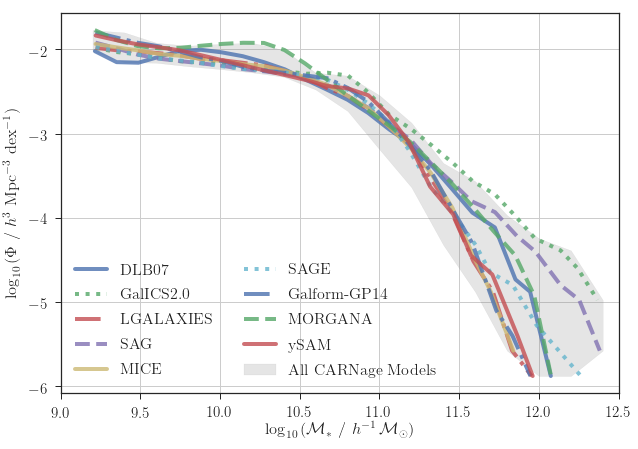

In [57]:
qa_carnage_smf(fullrange=True)

### Observed stellar mass functions

Data taken from Huang+18.

In [58]:
def read_li09():
    """Read data from Li & White 2009."""

    lidir = os.path.join(os.getenv('CATALOGS_DIR'), '09li')
    smffile = os.path.join(lidir, 'massfun.dr72bbright0')

    data = ascii.read(smffile, format='basic', names=('masslo', 'masshi', 'meanmass', 'phi', 'phierr'))
    
    mstar = data['meanmass'] - 2*np.log10(0.7)
    phi = np.log10(data['phi'].data * 0.7**3)
    phierr = data['phierr'] / data['phi'] / np.log(10)
    
    return mstar, phi, phi-phierr, phi+phierr

In [59]:
def read_moustakas13(starforming=False, quiescent=False):
    """Read data from Moustakas+13."""

    moosedir = os.path.join(os.getenv('CATALOGS_DIR'), '13moustakas')
    
    suffix = 'all'
    if starforming:
        suffix = 'starforming'
    if quiescent:
        suffix = 'quiescent'
    smffile = os.path.join(moosedir, 'smf_{}_supergrid01.txt'.format(suffix))

    data = ascii.read(smffile, format='basic', names=('zlo', 'zhi', 'ngal', 'mstar', 
                                                      'limit', 'phi', 'philo', 'phihi', 
                                                      'phicv'))
    loz = np.where( data['zhi'] <= 0.2 )[0]
    data = data[loz]
    
    return data['mstar'], data['phi'], data['phi'] - data['phicv'], data['phi'] + data['phicv']

In [60]:
def read_bernardi17(h=hdefault, dustfree=True):
    """Read data from Bernardi+17."""
    moosedir = os.path.join(os.getenv('CATALOGS_DIR'), '17bernardi')
    data = pd.read_table(os.path.join(moosedir, 'smf.txt'), 
                         delim_whitespace=True)

    mstar = data['mstar'].values # - np.log10(h**2)
    if dustfree:
        phi = data['phi_M14_dustfree_obs'].values # + np.log10(h**3)
        philo = phi - data['phierr_M14_dustfree'].values
        phihi = phi + data['phierr_M14_dustfree'].values
    else:
        phi = data['phi_M14_dust_obs'].values # + np.log10(h**3)
        philo = phi - data['phierr_M14_dust'].values
        phihi = phi + data['phierr_M14_dust'].values
    
    return mstar, phi, philo, phihi

In [61]:
def read_huang18(cModel=False, BCG=False, total=False, h=hdefault):
    
    huangdir = os.path.join(os.getenv('CATALOGS_DIR'), '18huang')

    if BCG:
        censuffix = 'cenhighmh'
    else:
        censuffix = 'cenlowmh'
        
    if cModel:
        fluxsuffix = 'cmodel'
    else:
        fluxsuffix = '100kpc'

    if total:
        data = Table.read(os.path.join(huangdir, 's16a_massive_{}_{}_smf.fits'.format('cenhighmh', fluxsuffix)))
        _data = Table.read(os.path.join(huangdir, 's16a_massive_{}_{}_smf.fits'.format('cenlowmh', fluxsuffix)))
        #print(data['logm_mean'], data['smf'].data, _data['smf'].data)
        
        data['smf'] += _data['smf']
        data['smf_err'] = np.sqrt( data['smf_err']**2 + _data['smf_err']**2 )
        data['smf_low'] = np.sqrt( data['smf_low']**2 + _data['smf_low']**2 )
        data['smf_upp'] = np.sqrt( data['smf_upp']**2 + _data['smf_upp']**2 )
    else:
        smffile = os.path.join(huangdir, 's16a_massive_{}_{}_smf.fits'.format(censuffix, fluxsuffix))
        data = Table.read(smffile)
    
    good = np.where( (data['logm_0'] >= 11.4) * (data['smf_err'] > 0) )[0]
    mstar = data['logm_mean'][good] # - 2*np.log10(h)
    phi = np.log10(data['smf'][good]) # * h**3)
    phierr = data['smf_err'][good] / data['smf'][good] / np.log(10)
    philo = phi - data['smf_low'][good] / data['smf'][good] / np.log(10)
    phihi = phi + data['smf_upp'][good] / data['smf'][good] / np.log(10)
    
    return mstar, phi, philo, phihi

In [62]:
def double_schechter(logmass, logmstar1=10.0, logmstar2=11.0, 
                     alpha1=-1, alpha2=-1.1, phistar1=0.008, 
                     phistar2=0.001):
    
    mratio1 = pow(10, logmass - logmstar1)
    mratio2 = pow(10, logmass - logmstar2)
    model = np.log(10) * ( np.exp(-mratio1) * phistar1 * mratio1**(alpha1 + 1) + 
                           np.exp(-mratio2) * phistar2 * mratio2**(alpha2+1) )
    
    return model

def read_dsouza15(h=hdefault):
    logmass = np.arange(9.5, 12.5, 0.05)
    
    phimodel = double_schechter(logmass, logmstar1=10.615, logmstar2=10.995,
                                alpha1=-1.082, alpha2=-1.120, 
                                phistar1=0.008579, phistar2=0.000355)
    
    logmass = logmass - np.log10(h**2)
    logphi = np.log10(phimodel * h**3)
    good = np.where(logphi > -7.6)[0]
    
    return logmass[good], logphi[good]

In [63]:
def qa_smf(plot_carnage=True, plot_huang=True, png=None):
    fig, ax = plt.subplots(figsize=(10, 7))

    # Model shaded region
    if plot_carnage:
        mstar, phimin, phimax = read_carnage_smf(fullrange=True, seed=1)
        ax.fill_between(mstar, phimin, phimax, alpha=0.2, color='gray', 
                        label='CARNage Models ($z\sim0$)')

    # Li & White 09
    mstar, phi, philo, phihi = read_li09()
    ax.fill_between(mstar, philo, phihi, alpha=0.3)
    ax.plot(mstar, phi, lw=3, ls='-', label='Li \& White 09 ($z\sim0.1$)')

    # Moustakas+13
    mstar, phi, philo, phihi = read_moustakas13()
    ax.fill_between(mstar, philo, phihi, alpha=0.3)
    ax.plot(mstar, phi, lw=3, ls='-', label='Moustakas+13 ($z\sim0.1$)')
    
    # D'Souza+15
    mstar, phi = read_dsouza15()
    ax.fill_between(mstar, phi, phi, alpha=0.3)
    ax.plot(mstar, phi, lw=3, ls='-', label="D'Souza+15 ($z\sim0.1$)")
    
    # Bernardi+17
    mstar, phi, philo, phihi = read_bernardi17(dustfree=True)
    ax.fill_between(mstar, philo, phihi, alpha=0.3)
    ax.plot(mstar, phi, lw=3, ls='-', label='Bernardi+17 ($z\sim0.1$)')

    # Huang+18
    if plot_huang:
        mstar, phi, philo, phihi = read_huang18(cModel=False, BCG=False, total=True)
        ax.fill_between(mstar, philo, phihi, alpha=0.3)
        ax.plot(mstar, phi, lw=3, ls='-', label='Huang+18 (z~0.4)')# (HSC, <100 kpc)')

    ax.set_xlabel(mstar_label3())
    ax.set_ylabel(phi_label2())
    
    ax.set_ylim(-7.7, -1.5)
    ax.set_xlim(9, 12.5)
    
    ax.grid()
    hh, ll = ax.get_legend_handles_labels()
    #handles = handles[np.array(list(1, 2, 0
    #labels = labels[np.array([1, 2, 0])]
    ax.legend(loc='lower left', fontsize=18)
    #ax.legend([hh[0],hh[1],hh[2],hh[3]], [ll[0],ll[1],ll[2]], loc='lower left', fontsize=18)
    
    if png:
        plt.savefig(png)    

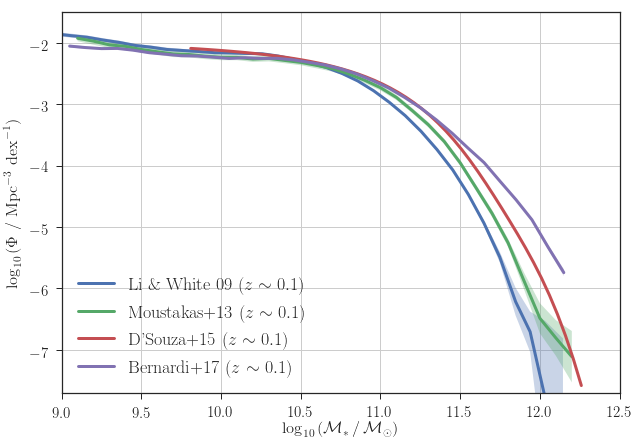

In [64]:
qa_smf(plot_carnage=False, plot_huang=False, png=os.path.join(talkdir, 'smf-data-nohuang.png'))

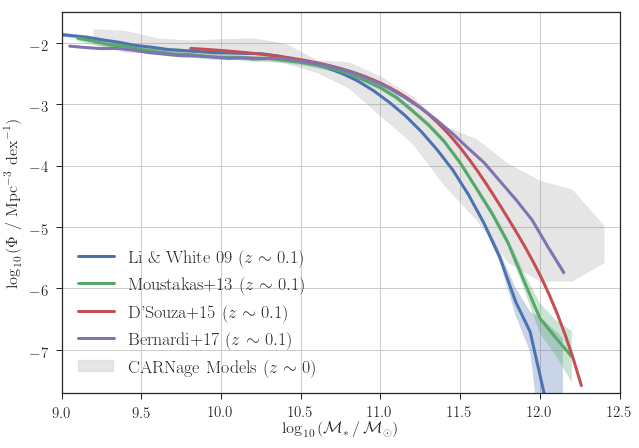

In [65]:
qa_smf(plot_carnage=True, plot_huang=False, png=os.path.join(talkdir, 'smf-data-carnage-nohuang.png'))